# Processing SAR (Synthetic Aperture Radar) data to TileDB arrays:
### using TileDB in combination with GDAL and Rasterio

Synthetic Aperture Radar - or SAR - is a type of remote sensing (satellite earth imaging) that works by measuring energy reflected back from a surface. It is especially good at detecting complex structures on that surface. 

Let's say you have a complicated set of skyscrapers with different heights and shapes in a city center, SAR could be a good way to capture a lot of that detail.

In this notebook, we will:
  - Download SAR images in Goereferenced TIFF (GeoTIFF) format (this format works well with GDAL and Rasterio).
  - Use the TileDB Writer for GDAL to write them to a TileDB array for storage/access. [(GDAL TileDB Driver)](https://github.com/OSGeo/gdal/blob/master/gdal/frmts/tiledb/tiledbdataset.cpp)
  - Use the TileDB Reader for Rasterio to open, read, and transform that TileDB array in a way that we can then easily visualize as an image.

Note: the data used here is openly licensed from the Spacenet 6 challenge.

Let's prepare some of the geospatial, data, and visualization tools we'll be using.

GDAL and Rasterio should both already be in the active environment you've set up earlier, so we just need to bring in the parts we'll need for the Python code.

In [1]:
import os
import shutil

import json
from matplotlib import pyplot
import numpy as np
import rasterio
from rasterio.plot import (
    show,
    reshape_as_raster,
    reshape_as_image,
    adjust_band
)
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rasterio.crs import CRS

Now, let's download the two SAR GeoTIFF images we'll be using from the Spacenet s3 storage.

These are over the port of Rotterdam in Amsterdam. 

About the images:

Each image is at a resolution of 0.25m and has 6 bands: 
  - 4 measuring SAR Intensity:
    - 1: HH , 2: HV, 3: VH, 4: VV

  - 2 related to backscatter and derived from Pauli decomposition (beyond this exercise scope - tl;dr - they're good for distinguishing different types of objects):
    - 5: alpha² & 6: beta²
      - Note: there's also gamma² = 2 * HV

In the following, we'll be using:
  - Band 1 (HH Intensity): output to Red
  - Band 4 (VV Intensity): output to Green
  - Band 2 (HV Intensity): output to Blue
 
For more on SAR data, see [NASA Earthdata](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar)  
For more on Spacenet's SAR image bands, see [Spacenet Medium Article](https://medium.com/the-downlinq/spacenet-6-expanded-dataset-release-e1a7ddaf030)

In [11]:
image_1 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804111224_20190804111453.tif"
image_2 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804113009_20190804113242.tif"

if not os.path.exists("tmp"):
    os.mkdir("tmp")

for image in (image_1, image_2):
    if not os.path.exists(f"./tmp/{image}"):
        !aws s3 cp s3://spacenet-dataset/AOIs/AOI_11_Rotterdam/SAR-MAG-POL/$image ./tmp/

# rename the image data files
image_1 = f"./tmp/{image_1}"
image_2 = f"./tmp/{image_2}"

You should see an output counter with the progress of the two image downloads. We need both to complete before moving on.

These might take awhile, so if they aren't done and you still want to code along, you can use the corresponding smaller images stored in a local folder. The results will be similar but with a poorer resolution. Just run the cell immediately below this one.

In [9]:
# Note: DO NOT RUN IF YOU ALREADY HAVE THE LARGER IMAGES DOWNLOADED

image_1 = "../data/SAR_images/image_1.tif"
image_2 = "../data/SAR_images/image_2.tif"

Let's use rasterio to get some more details about these two georeferenced images. 

In [12]:
!rio info $image_1 | jq .
!rio info $image_2 | jq .

{
  "bounds": [
    592317.4837528648,
    5749199.061398174,
    602998.4837528648,
    5749906.311398174
  ],
  "colorinterp": [
    "gray",
    "undefined",
    "undefined",
    "undefined",
    "undefined",
    "undefined"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "GTiff",
  "dtype": "float32",
  "height": 2829,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "pixel",
  "lnglat": [
    4.419039098958206,
    51.88817718874352
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    0.25,
    0.25
  ],
  "shape": [
    2829,
    42724
  ],
  "tiled": false,
  "transform": [
    0.25,
    0,
    592317.4837528648,
    0,
    -0.25,
    5749906.311398174,
    0,
    0,
    1
  ],
  "units": [
 

We can also parse the info and extract the image bounds. This will help us when we want to look at different parts of the images.  

Note: bounds are entered in this order: 

Left, Bottom, Right, Top

In [ ]:
image_1_info = !rio info $image_1
image_2_info = !rio info $image_2

image_1_info, image_2_info = json.loads(image_1_info[0]), json.loads(image_2_info[0])

image_1_bds = image_1_info["bounds"]
image_2_bds = image_2_info["bounds"]

print(f"image_1_bounds: {image_1_bds}\nimage_2_bounds: {image_2_bds}")

For ease-of-use, we'll switch those over to latitude/longitude units.

In [ ]:
image_1_bounds = transform_bounds(image_1_info["crs"], CRS.from_epsg(4326), *image_1_bds)

image_2_bounds = transform_bounds(image_2_info["crs"], CRS.from_epsg(4326), *image_2_bds)

print(f"image_1_bounds lat/lon: {image_1_bounds}\nimage_2_bounds lat/lon: {image_2_bounds}")

Now let's take both of those images, mosaic them with GDAL's buildvrt, and then write and store that mosaic image as a TileDB array using the TileDB writer plugin for GDAL.

In [13]:
output_array = "arrays/sar_output_array"

# clean up previous runs
try:
    shutil.rmtree(output_array)
except:
    pass

!gdalbuildvrt mosaic.vrt $image_1 $image_2
!gdal_translate -OF TileDB -CO BLOCKXSIZE=1024 -CO BLOCKYSIZE=1024 -CO COMPRESSION=ZSTD -CO COMPRESSION_LEVEL=7 mosaic.vrt $output_array

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 43971, 4966
0...10...20...30...40...50...60...70...80...90...100 - done.


Using `rasterio`'s cli function `rio info` we can look at the info of that output array. (Note how `rio` is able to process georeferenced files in TileDB format.)

In [14]:
!rio info $output_array | jq .

{
  "blockxsize": 1024,
  "blockysize": 1024,
  "bounds": [
    592283.6673783489,
    5749199.021989683,
    603276.4173783489,
    5750440.521989683
  ],
  "colorinterp": [
    "red",
    "green",
    "blue",
    "alpha",
    "alpha",
    "alpha"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "TileDB",
  "dtype": "float32",
  "height": 4966,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "band",
  "lnglat": [
    4.42088782517541,
    51.890556453687125
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    0.25,
    0.25
  ],
  "shape": [
    4966,
    43971
  ],
  "tiled": true,
  "transform": [
    0.25,
    0,
    592283.6673783489,
    0,
    -0.25,
    5750440.521989683,
    0,
    0,
    

Once again, we'll parse that info to get the mosaic's bounds. And, we'll then transform it to latitude/longitude.

In [15]:
output_info = !rio info $output_array
output_info = json.loads(output_info[0])
output_bds = output_info["bounds"]
print(f"output_bounds: {output_bds}\n")
output_bounds = transform_bounds(output_info["crs"], CRS.from_epsg(4326), *output_bds)
print(f"output_bounds lat/lon: {output_bounds}")

output_bounds: [592283.6673783489, 5749199.021989683, 603276.4173783489, 5750440.521989683]

output_bounds lat/lon: (4.340875661992832, 51.883985849254564, 4.500915336875932, 51.89707327920041)


For the final step, we'll open this TileDB array back up into a georeferenced image and take a look at it.

Using the standard `rasterio.open`, the TileDB Reader plugin is called and integrates the output easily with the other raster formats used with rasterio.

Note: TileDB storage is optimized for 'windowed' reading, so you can query just what you need, without downloading any unneccessary data. You can see this below in the bounding box `bbox` we used which integrates easily with `rasterio.Window` to get only a part of the image.

We've set up a function that opens and shows a window within the mosaic output array.

You just need to choose what area within the output bounds we want to look at.

Here are the mosaic image bounds again:

In [ ]:
output_bounds

And we'll pick this area, for illustration purposes:

In [16]:
lat_lon_bbox = [4.34, 51.885, 4.37, 51.897]

In the code below, we:
  - Set up a window in the native crs units
  - Read the Red, Green, Blue bands in this window
  - Normalize the values to (0 - 1.0) for pixel coloring
  - Use `matplotlib.pyplot` and rasterio's `show` to display the resulting image

window shape: (3, 4966, 8025)



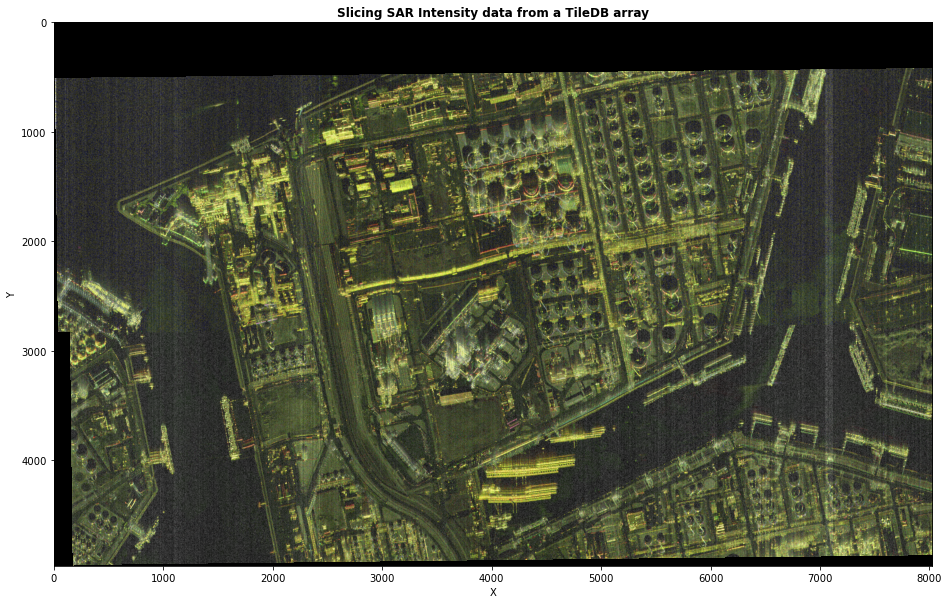

In [17]:
with rasterio.Env():
    with rasterio.open(output_array) as src:
        # query dataset in lat/lon coordinates
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

        img = src.read((1, 4, 2), window=bounds_window)
        print(f"window shape: {img.shape}\n")

        arr = reshape_as_raster(img)
        for b, band in enumerate(arr):
            arr[b] = adjust_band(band)
        arr = reshape_as_image(arr)

        fig, ax = pyplot.subplots(1, 1, figsize=(20, 10))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        show(arr, ax=ax, title="Slicing SAR Intensity data from a TileDB array")

Note the uneven edges in the output image in areas where the mosaic images have been fit together.

You can play around with the lat/lon window and set the global `lat_lon_bbox` variable to whatever you want, as long as there's overlap with the output_bounds.

Try entering it below in the order [Left, Bottom, Right, Top] and then reruning the cell above.

(Note: if you're running the larger images and using a big window, this can take some time.)

In [ ]:
lat_lon_bbox = "set your own lat/lon bbox"

In the code above, we extracted bands 1 (HH), 4 (VV), and 2 (HV) for Red, Green, and Blue.

We can also use other combinations to extract more detail from these images.

The backscatter bands, including 5 (alpha²) and 6 (beta²), are good for distiguishing different types of objects.

Try setting up an image using these bands to see the kind of detail you get.
You can set it up as in the following:

beta²: Red

gamma²: Green

alpha²: Blue

(see [Spacenet Medium Article](https://medium.com/the-downlinq/spacenet-6-expanded-dataset-release-e1a7ddaf030) from above)

The following cells already have the extrapolation of the gamma² band set up, so you just need to add the other two.

Reset the lat_lon_bbox as before, then run the cells after that as well to get the gamma band.

In [18]:
lat_lon_bbox = [4.34, 51.885, 4.37, 51.897]

In [19]:
def get_gamma_sq(lat_lon_bbox):
    with rasterio.Env():
        with rasterio.open(output_array) as src:
            # query dataset in lat/lon coordinates
            native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
            bounds_window = src.window(*native_bounds)
            bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

            img = src.read((2,), window=bounds_window)
            for b, band in enumerate(img):
                img[b] = band * 2
            return img

In [20]:
gamma2 = get_gamma_sq(lat_lon_bbox)

Finally, set up the `src.read()` method to set up the image with the correct bands.

window shape: (3, 4966, 8025)



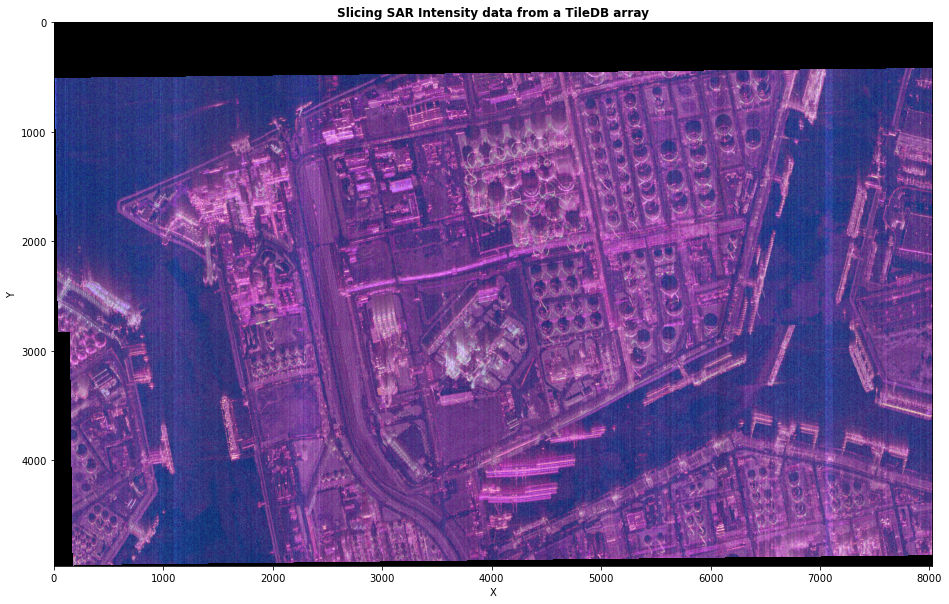

In [22]:
with rasterio.Env():
    with rasterio.open(output_array) as src:
        # query dataset in lat/lon coordinates
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

        img = "...write read method here"

        img = np.concatenate((img[:1], gamma2, img[1:]), axis=0)
        arr = reshape_as_raster(img)
        for b, band in enumerate(arr):
            arr[b] = adjust_band(band)
        arr = reshape_as_image(arr)
        print(f"window shape: {arr.shape}\n")

        fig, ax = pyplot.subplots(1, 1, figsize=(20, 10))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        show(arr, ax=ax, title="Slicing SAR Intensity data from a TileDB array")